This sample script showcases the use of the `NmtWorkspace()` class to speed up the computation of multiple power spectra with the same mask.

This is the most general example in this suite, showing also the correct way to compare the results of the MASTER estimator with the theory power spectrum.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from __future__ import print_function
from __future__ import division

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# Import the NaMaster python wrapper
import pymaster as nmt

In [4]:
# HEALPix map resolution
nside = 256

We start by creating some synthetic masks and maps with contaminants. Here we will focus on the cross-correlation of a spin-2 and a spin-1 field.

In [6]:
# a) Read and apodize mask
mask = nmt.mask_apodization(
    hp.read_map("../test/mask.fits", verbose=False),
    1.,
    apotype="Smooth")

In [8]:
# b) Read maps
mp_t, mp_q, mp_u = hp.read_map("../test/maps.fits", field=[0, 1, 2], verbose=False)

In [9]:
# c) Read contaminants maps
tm_t, tm_q, tm_u = hp.read_map("../test/temp.fits", field=[0, 1, 2], verbose=False)

In [10]:
# d) Create contaminated fields
#   Spin-0
f0 = nmt.NmtField(mask, [mp_t + tm_t], templates=[[tm_t]])
#   Spin-2
f2 = nmt.NmtField(mask, [mp_q + tm_q, mp_u + tm_u], templates=[[tm_q,tm_u]])

In [11]:
# e) Create binning scheme. We will use 20 multipoles per bandpower.
b = nmt.NmtBin(nside, nlb=20)

In [13]:
# f) Finally, we read our best guess for the true power spectrum. We will
#   use this to:
#   i)  Compute the bias to the power spectrum from contaminant cleaning
#   ii) Generate random realizations of our fields to compute the errors
l, cltt, clee, clbb, clte = np.loadtxt("../test/cls.txt",unpack=True)
cl_02_th = np.array([clte, np.zeros_like(clte)])

We then generate an NmtWorkspace object that we use to compute and store the mode coupling matrix.

Note that this matrix depends only on the masks of the two fields to correlate, but not on the maps themselves (in this case both maps are the same).

In [14]:
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f0, f2, b)

Since we suspect that our maps are contaminated (that's why we passed the contaminant templates as arguments to the `NmtField` constructor), we also need to compute the bias to the power spectrum caused by contaminant cleaning (deprojection bias).

In [17]:
cl_bias = nmt.deprojection_bias(f0, f2, cl_02_th)

The function defined below will compute the power spectrum between two `NmtFields` `f_a` and `f_b`, using the coupling matrix stored in the NmtWorkspace wsp and subtracting the deprojection bias clb.

Note that the most expensive operations in the MASTER algorithm are the computation of the coupling matrix and the deprojection bias. Since these two objects are precomputed, this function should be pretty fast!

In [15]:
def compute_master(f_a, f_b, wsp,clb) :
    """
    Compute the power spectrum (a la anafast) of the masked fields
    Note that we only use n_iter=0 here to speed up the computation,
    but the default value of 3 is recommended in general.
    """
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b, n_iter=0)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled, cl_bias=clb)

    return cl_decoupled

In [18]:
# OK, we can now compute the power spectrum of our two input fields
cl_master = compute_master(f0, f2, w, cl_bias)

/Users/dlenz/anaconda/envs/py27/lib/python2.7/site-packages/pymaster/workspaces.py:70: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if cl_bias!=None :


Let's now compute the errors on this estimator using 100 Gaussian random simulations. In a realistic scenario you'd want to compute the full covariance matrix, but let's keep things simple.

In [21]:
nsim=100
cl_mean =np.zeros_like(cl_master)
cl_std = np.zeros_like(cl_master)
for i in np.arange(nsim):
    print("{}d-th simulation".format(i))
    t, q, u = hp.synfast([cltt, clee, clbb, clte], nside, verbose=False)
    f0_sim = nmt.NmtField(mask, [t], templates=[[tm_t]])
    f2_sim = nmt.NmtField(mask, [q, u], templates=[[tm_q, tm_u]])
    cl = compute_master(f0_sim, f2_sim, w, cl_bias)
    cl_mean += cl
    cl_std += cl * cl

cl_mean /= nsim
cl_std = np.sqrt(cl_std / nsim - cl_mean * cl_mean)

0d-th simulation
1d-th simulation
2d-th simulation
3d-th simulation
4d-th simulation
5d-th simulation
6d-th simulation
7d-th simulation
8d-th simulation
9d-th simulation
10d-th simulation
11d-th simulation
12d-th simulation
13d-th simulation
14d-th simulation
15d-th simulation
16d-th simulation
17d-th simulation
18d-th simulation
19d-th simulation
20d-th simulation
21d-th simulation
22d-th simulation
23d-th simulation
24d-th simulation
25d-th simulation
26d-th simulation
27d-th simulation
28d-th simulation
29d-th simulation
30d-th simulation
31d-th simulation
32d-th simulation
33d-th simulation
34d-th simulation
35d-th simulation
36d-th simulation
37d-th simulation
38d-th simulation
39d-th simulation
40d-th simulation
41d-th simulation
42d-th simulation
43d-th simulation
44d-th simulation
45d-th simulation
46d-th simulation
47d-th simulation
48d-th simulation
49d-th simulation
50d-th simulation
51d-th simulation
52d-th simulation
53d-th simulation
54d-th simulation
55d-th simulation
56

One final thing needs to be done before we can compare the result with the theory. The theory power spectrum must be binned into bandpowers in the same manner the data has. This is straightforward to do using just two nested function calls.

In [22]:
cl_02_th_binned = w.decouple_cell(w.couple_cell(cl_02_th))

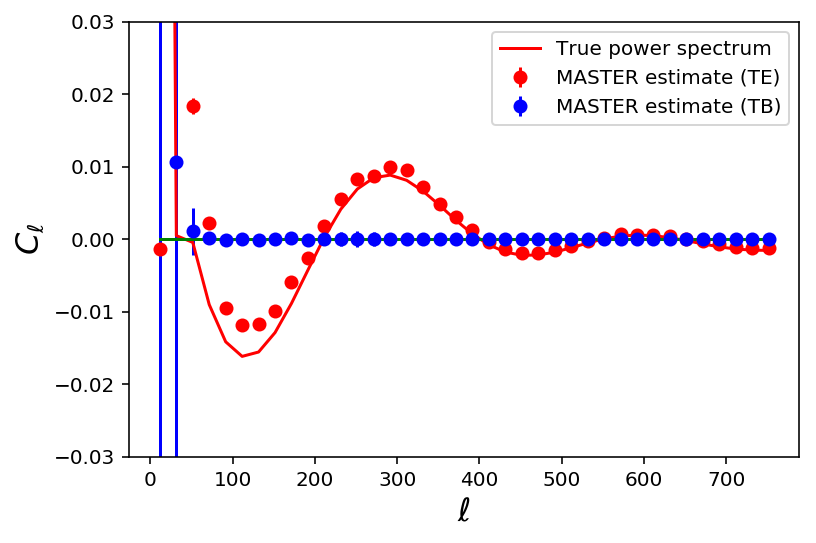

In [23]:
# Now let's plot the result!
plt.plot(b.get_effective_ells(), cl_02_th_binned[0], 'r-', label='True power spectrum')
plt.plot(b.get_effective_ells(), cl_02_th_binned[1], 'g-')

plt.errorbar(b.get_effective_ells(), cl_master[0], yerr=cl_std[0],
             fmt='ro', label='MASTER estimate (TE)')
plt.errorbar(b.get_effective_ells(), cl_master[1], yerr=cl_std[1],
             fmt='bo', label='MASTER estimate (TB)')

# limits & labels
plt.ylim([-0.03, 0.03])
plt.legend(loc='upper right')
plt.xlabel('$\\ell$',fontsize=16)
plt.ylabel('$C_\\ell$',fontsize=16);